# Подготовка данных пациентов

In [1]:
# standard
import pandas as pd
import numpy as np
import re
import seaborn as sbs
import matplotlib.pyplot as plt
import matplotlib
from tqdm import notebook
sbs.set_style("darkgrid")

# text processing
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem

# preprocessing/processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_validate,  StratifiedKFold
import imblearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# metrics
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import recall_score, f1_score, precision_score

# base models
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# model building
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Загрузка данных

In [2]:
file_path = 'chd_addmit_300.xlsx'

In [5]:
patient_data = pd.read_excel(file_path)

In [6]:
patient_data.head()

,admittion,discharge,sex,height,weight,BMI,BSA,birth,Операции (все в ИБ),Перенесенные опер. (из Анамн.),...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2016-12-12,2017-01-10,m,76,9.70,111.27,0.46,02.01.2016,12.12.2016: (Откр./ИК) Перевязка ранее наложен...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-13,2017-02-01,f,67,7.34,89.67,0.37,02.02.2016,18.01.2017: (Откр./ИК) Радикальная коррекция д...,15.08.2016г.: Транслюминальная балонная вальву...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-17,2017-02-09,m,74,8.90,103.46,0.43,21.02.2016,19.01.2017: (Откр./ИК) Перевязка ранее наложен...,29.02.2016 - подключично-легочный анастомоз сп...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-20,2017-02-21,f,67,6.97,85.15,0.36,02.03.2016,23.01.2017: (Откр./ИК) Наложение двустороннего...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-13,2017-03-01,m,82,9.29,102.59,0.46,08.03.2016,15.02.2017: (Откр./ИК) Реконструкция путей отт...,13.04.2016. НАЗВАНИЕ ОПЕРАЦИИ: Транслюминальна...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 42 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   admittion                                        300 non-null    datetime64[ns]
 1   discharge                                        300 non-null    datetime64[ns]
 2   sex                                              300 non-null    object        
 3   height                                           300 non-null    int64         
 4   weight                                           300 non-null    float64       
 5   BMI                                              298 non-null    float64       
 6   BSA                                              298 non-null    float64       
 7   birth                                            300 non-null    object        
 8   Операции (все в ИБ)                     

In [8]:
patient_data.describe()

,height,weight,BMI,BSA,target,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
count,300.000000,300.000000,298.000000,298.000000,300.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,64.890000,6.293560,76.834430,0.336477,0.046667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.076012,1.951695,20.640196,0.073846,0.211276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,39.000000,1.270000,20.340000,0.120000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,60.000000,4.868500,62.007500,0.280000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65.500000,6.442500,78.430000,0.350000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,71.000000,7.651250,91.797500,0.390000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,85.000000,12.000000,137.650000,0.520000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Успешно создан датасет. Необходимо изменить тип данных некоторых признаков, убрать пропуски.

## Предобработка

### Main dataset

In [13]:
main_dataset = pd.DataFrame()

In [14]:
main_dataset[['sex',
              'height',
              'weight',
              'BMI','BSA',
              'operations',
              'echo',
              'target']] = patient_data[['sex',
                                         'height',
                                         'weight',
                                         'BMI',
                                         'BSA',
                                         'Операции (все в ИБ)',
                                         'ЭКГ (Из Эпикр. до опер.)',
                                         'target']]

### Уберем пропуски

In [15]:
main_dataset.isnull().sum()

sex            0
height         0
weight         0
BMI            2
BSA            2
operations     0
echo          20
target         0
dtype: int64

In [16]:
main_dataset = main_dataset.dropna()

In [17]:
main_dataset.isnull().sum()

sex           0
height        0
weight        0
BMI           0
BSA           0
operations    0
echo          0
target        0
dtype: int64

### Обработка текста

In [17]:
m = Mystem()

# Леммантизирует текст
def lemmatize(text):
    return "".join(m.lemmatize(text))

def clear_text(text):
    cleaned = re.sub(r'[^а-яА-Яa-zA-ZёЁ ]', ' ', text)
    cleaned = cleaned.split()
    return ' '.join(cleaned)

In [327]:
%%time

main_dataset['operations'] = main_dataset['operations'].apply(lambda x: clear_text(lemmatize(x)))

CPU times: total: 656 ms
Wall time: 4min 6s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [328]:
%%time

main_dataset['echo'] = main_dataset['echo'].apply(lambda x: clear_text(lemmatize(x)))

CPU times: total: 1.19 s
Wall time: 8min 14s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
main_dataset.sample(5)

,sex,height,weight,BMI,BSA,operations,echo,target
25,m,68,6.450,76.40,0.35,16.02.2017: (Откр./ИК) Перевязка ранее наложен...,ЭКГ (28.01.2017 8:28:47)\nРитм синусовый. ЧСС ...,0
117,m,62,4.320,54.86,0.27,31.05.2017: (Откр./ИК) Операция Norwood I с на...,"24.05.2017\nРитм синусовый, ЭОС отклонена впра...",0
141,f,65,6.565,81.43,0.35,09.03.2017: (Закрыт.) Наложение модифицированн...,"17.02.2017 Ритм синусовый, правильный с частот...",0
20,f,71,8.000,94.94,0.40,05.04.2017: (Эндоваск.) Транслюминальная балон...,6.03.2017\nРитм сердца синусовый. Частота серд...,0
54,f,73,8.780,102.76,0.43,28.04.2017: (Откр./ИК) Перевязка ранее наложен...,"14.04.17 Ритм синусовый, правильный. Вертикаль...",0


### Категории

In [19]:
main_dataset['sex'] = pd.get_dummies(main_dataset['sex'], drop_first=True)

In [20]:
main_dataset = main_dataset.drop('echo', axis=1)

In [21]:
main_dataset.sample(5)

,sex,height,weight,BMI,BSA,operations,target
61,0,68,5.30,64.27,0.32,16.03.2017: (Откр./ИК) Радикальная коррекция д...,0
44,1,70,7.40,88.45,0.38,19.01.2017: (Откр./ИК) Пластика дефекта межжел...,0
234,0,47,2.67,38.95,0.19,10.01.2017: (Эндоваск.) Транслюминальная балон...,0
95,0,73,6.21,72.68,0.36,25.05.2017: (Откр./ИК) Перевязка ранее наложен...,0
264,0,70,8.70,103.98,0.41,18.01.2017: (Эндоваск.) Транслюминальная балон...,0


### Обучение

#### Text Features Pipeline

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Стивен\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stopwords = nltk_stopwords.words('russian')

In [24]:
operations_transformer = TfidfVectorizer(stop_words=stopwords)

In [25]:
num_features = ['height', 'weight', 'BMI', 'BSA']

In [26]:
num_transformer = StandardScaler()

#### Column Transformer

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', operations_transformer, 'operations'),
        #('echo', operations_transformer, 'echo'),
        ('num', num_transformer, num_features)
    ],
    remainder='passthrough'
)

In [28]:
preprocessor.fit_transform(main_dataset).shape

(278, 342)

In [29]:
X, y = main_dataset.drop(['target'], axis=1), main_dataset['target']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [31]:
X_train.shape

(194, 6)

In [32]:
X_test.shape

(84, 6)

In [33]:
y_train.value_counts()

0    185
1      9
Name: target, dtype: int64

In [34]:
y_test.value_counts()

0    80
1     4
Name: target, dtype: int64

### Выбор модели

Сделаем пайплайн на примере кэтбуст. Проверим на кросс валидации

### Pipeline + RandomSearch

In [35]:
def create_pipeline(clf):
    pipeline = imbpipeline(
        steps=[
            ('preprocess', preprocessor),
            ('undersampler', RandomUnderSampler(sampling_strategy=0.1)),
            ('smote', SMOTE()),
            ('clf', clf)
        ]
    )
    return pipeline

In [36]:
def random_search(clf, params, n_iter=10):
    clf = create_pipeline(clf)
    return RandomizedSearchCV(clf,
                              params,
                              scoring='neg_log_loss',
                              n_jobs=-1,
                              n_iter=n_iter,
                              cv=StratifiedKFold(n_splits=3, shuffle=True),
                              verbose=5
                             )

In [37]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def thresholds_argmax(model, x, y):
    thresholds = np.arange(0, 0.9, 0.001)
    probs = model.predict_proba(x)[:, 1]
    scores = [roc_auc_score(y, to_labels(probs, t)) for t in thresholds]
    ix = np.argmax(scores)
    threshold = thresholds[ix]
    return (threshold)

In [38]:
def fit_data(model, show_feature_importance=False):
    clf_name = model.estimator['clf'].__class__.__name__
    print(f'Classifier name: {clf_name}')
    
    model = model.fit(X_train, y_train)
    print(f'Training finished!', '-'*100, sep='\n')
    print(f'Best score: = {model.best_score_}')
    print(f'Best parameters {model.best_params_}')
    
    if show_feature_importance:   
        try:
            if clf_name == 'CatBoostClassifier':
                feature_importance = model.best_estimator_['clf'].get_feature_importance()
            elif clf_name == 'XGBClassifier':
                feature_importance = model.best_estimator_['clf'].feature_importances_
            else:
                feature_importance = feature_importance = model.best_estimator_['clf'].feature_importance_
            main_features = pd.DataFrame(data = feature_importance[-5:], index=X.columns[:5]).sort_values(by=0)
            
            plt.figure(figsize=(10, 7))
            main_features.plot(kind='barh', ax=plt.gca())
            plt.title('Feature Importance without operations')
            plt.xlabel('Importance, %')
            plt.show()
        except:
            print('no feature importance')
    
    best_model = model.best_estimator_.fit(X_train, y_train)
    th = thresholds_argmax(best_model, X_test, y_test)
    print(f'Threshold: {th}')
    predictions = best_model.predict_proba(X_test)[:,1] > th
    print(f'Confusion Matrix:\n {confusion_matrix(y_test, predictions)}')
    print(classification_report(y_test, predictions))
    f1 = f1_score(y_test, predictions, labels=[1])
    precision = precision_score(y_test, predictions, labels=[1])
    recall = recall_score(y_test, predictions, labels=[1])
    
    return best_model, th, abs(model.best_score_), f1, precision, recall

### Перебор моделей

In [133]:
def look_through_models(models):
    names = []
    best_models = []
    data_list = []
    for model in notebook.tqdm(models):
        name = model.estimator['clf'].__class__.__name__
        try:
            data = fit_data(model)
            names.append(name)
            best_models.append(data[0])
            data_list.append(data[1:])
        except ValueError as e:
            print(f'Classifier {name} threw an exception: {e}')
        print('_'*100)
    
    data_df = pd.DataFrame(data=data_list, index=names)
    display(data_df)
    data_df[0].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('Threshold')
    plt.show()
    data_df[1].sort_values(0, ascending=False).plot(kind='barh', ax=plt.gca())
    plt.xlabel('Log loss score')
    plt.show()
    data_df[2].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('f1 score')
    plt.show()
    data_df[3].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('precision score')
    plt.show()
    data_df[4].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('recall score')
    plt.show()
    
    return best_models

#### Models

In [134]:
models = []

In [135]:
#Tree
parameters = {
    'clf__max_depth': range(3, 10),
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__class_weight': [None, 'balanced']
}

svc = random_search(DecisionTreeClassifier(),
                          parameters,
                          70)
models.append(svc)

In [136]:
#SGD
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__class_weight': [None, 'balanced']
}

svc = random_search(SGDClassifier(loss='log_loss'),
                          parameters,
                          60)
models.append(svc)

In [137]:
#KNN
parameters = {
    'clf__n_neighbors': range(3, 10),
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(KNeighborsClassifier(),
                          parameters,
                          40)
models.append(svc)

In [138]:
#Forest
parameters = {
    'clf__max_depth': range(3, 10),
    'clf__n_estimators': range(200, 2000, 200),
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__class_weight': [None, 'balanced']
}

svc = random_search(RandomForestClassifier(),
                          parameters,
                          120)
models.append(svc)

In [139]:
#Logistic
parameters = {
    'clf__C': [.1, 1, 10, 100, 1000],
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__class_weight': [None, 'balanced']
}

svc = random_search(LogisticRegression(),
                          parameters,
                          90)
models.append(svc)

In [140]:
#SVC
parameters = {
    'clf__gamma': [.1,.5,1,2,5,10],
    'clf__C': [.1, 1, 10, 100, 1000],
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__class_weight': [None, 'balanced']
}

svc = random_search(SVC(probability=True, kernel='rbf'),
                          parameters,
                          90)
models.append(svc)

In [141]:
#LightGBM
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__max_depth': range(2, 11),
    'clf__n_estimators': range(100, 1100, 100)
}

xgb_search = random_search(LGBMClassifier(),
                          parameters,
                          100)
models.append(xgb_search)

In [142]:
#XGB
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__max_depth': range(2, 11),
    'clf__n_estimators': range(100, 1100, 100)
}

xgb_search = random_search(XGBClassifier(),
                          parameters,
                          100)
models.append(xgb_search)

In [143]:
#CatBoost
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__depth': range(2, 11)
}

catboost_search = random_search(CatBoostClassifier(silent=True, iterations=750),
                                       parameters,
                                       100)
models.append(catboost_search)

#### Results

  0%|          | 0/9 [00:00<?, ?it/s]

Classifier name: DecisionTreeClassifier
Fitting 3 folds for each of 70 candidates, totalling 210 fits
Training finished!
----------------------------------------------------------------------------------------------------
Best score: = -1.7381935879206774
Best parameters {'smote__sampling_strategy': 0.3, 'preprocess__text__ngram_range': (1, 1), 'preprocess__text__max_df': 0.25, 'clf__max_depth': 4, 'clf__class_weight': None}
Threshold: 0.023
Confusion Matrix:
 [[68 12]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        80
           1       0.08      0.25      0.12         4

    accuracy                           0.82        84
   macro avg       0.52      0.55      0.51        84
weighted avg       0.92      0.82      0.86        84

____________________________________________________________________________________________________
Classifier name: SGDClassifier
Fitting 3 folds for each of 60 candidates, totalling 180 

,0,1,2,3,4
DecisionTreeClassifier,0.023,1.738194,0.117647,0.076923,0.25
SGDClassifier,0.577,0.729758,0.285714,0.200000,0.50
KNeighborsClassifier,0.201,0.434341,0.148148,0.086957,0.50
RandomForestClassifier,0.066,0.171664,0.190476,0.105263,1.00
LogisticRegression,0.114,0.200768,0.275862,0.160000,1.00
SVC,0.024,0.193100,0.156863,0.085106,1.00
LGBMClassifier,0.237,0.318222,0.173913,0.105263,0.50
XGBClassifier,0.197,0.198431,0.363636,0.285714,0.50
CatBoostClassifier,0.049,0.160509,0.200000,0.111111,1.00


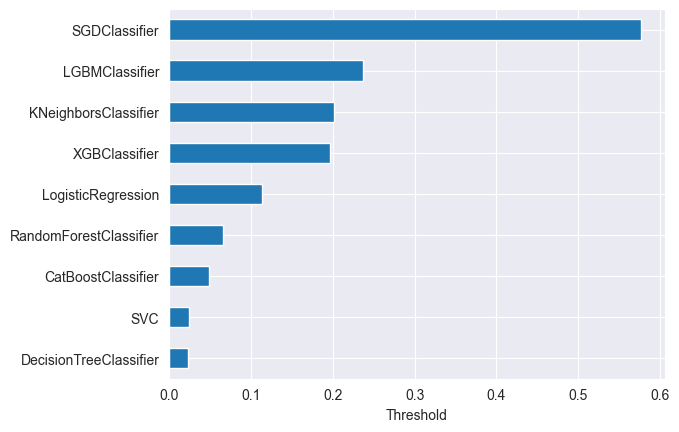

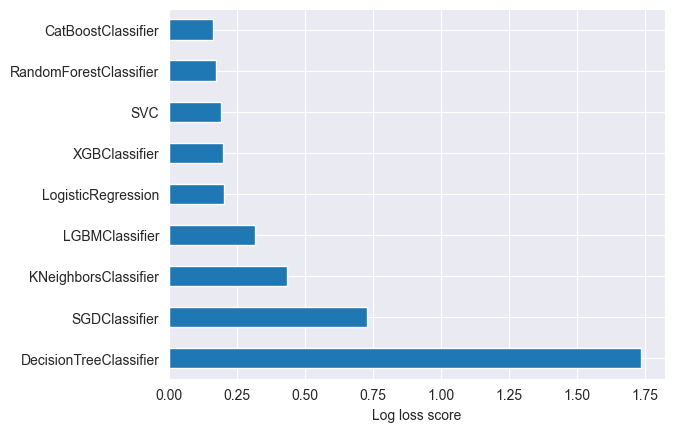

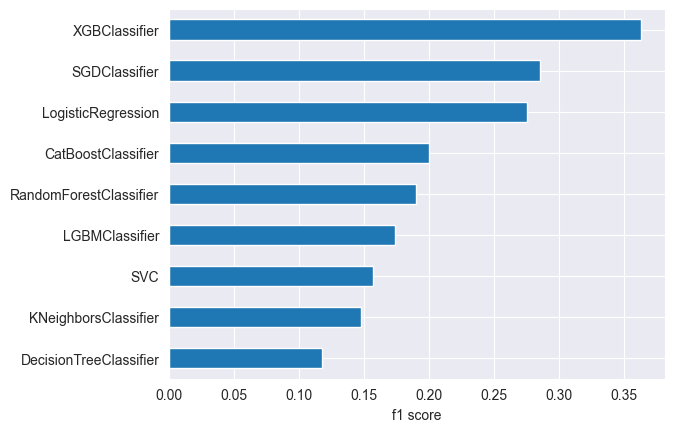

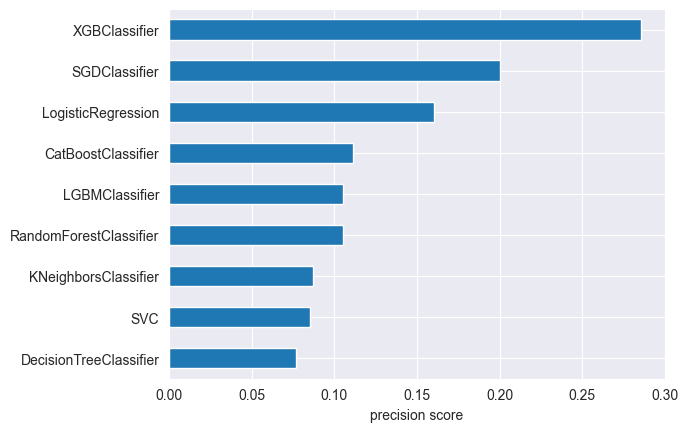

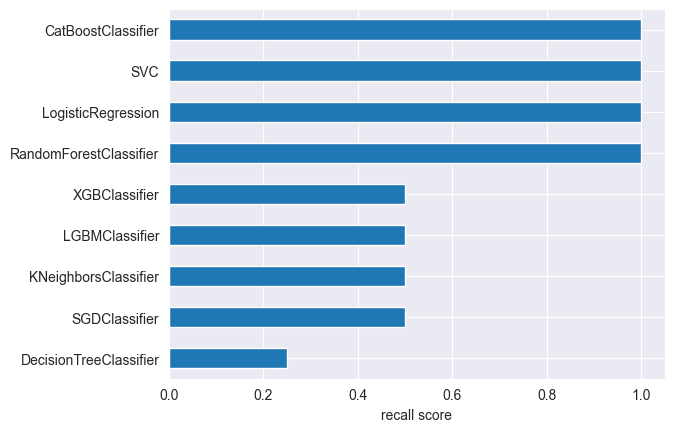

In [144]:
look_through_models(models);